# KD線交易策略驗證
Author：余慶龍  
Establish Date：2021.7.25  
Last Modified Date：2021.7.25  

## Table of Contents
1. 讀取檔案模塊
2. 指標與交易策略
3. 回測模塊
4. Main：執行上面的模塊

## 1. 讀取檔案模塊

In [9]:
"""
把csv或excel檔案轉換成dataframe
以供後續的pandas操作
"""

import pandas as pd
import numpy as np
from datetime import datetime

def readStock_file(file, filetype='csv'):


    if filetype == 'excel':
        df = pd.read_excel(file, engine='openpyxl', parse_dates=True, header=None)
    else:
        df = pd.read_csv(file)

    # 取代原本的 column 名稱
    # 檔案的日期與開高低收需要照這個順序
    colume_name = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.columns = colume_name

    # 用日期這一行當做 df 的索引
    df = df.set_index('Date')

    # 把日期轉成 datetime的格式(從string)
    df.index = pd.to_datetime(df.index)

    # 照日期排序並把空資料轉成numpy的nan
    df = df.sort_index()
    df = df.replace(r'^\s*-$', np.nan, regex=True)


    for col in df.columns:
        if(col=='Date'):
            continue;
        df[col] = np.array([float(x) for x in df[col]])

    return df

def random_sample(ticker_list_file,  column = '證券代碼', times = 10):
    

    ticker_list_df = pd.read_csv(ticker_list_file, encoding='utf8', usecols=[column])
    ticker_list = ticker_list_df[column].to_list()
    
    sample = np.random.choice(ticker_list, times)
    sample_list = [i.replace(' ', '') for i in sample.tolist()]

    return sample_list

def file_list_with_directory(file_list, path):
    
    files = [path+i+'.csv' for i in file_list]
    return files

def get_dataframe(data_file, days=0):
    ticker = pd.read_csv(data_file)

    # change the name of columns
    ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # set the column "Date" to index
    ticker = ticker.set_index('Date')

    # set index column("Date") from string to datetime.datetime
    ticker.index = pd.to_datetime(ticker.index)

    # sort index column("Date") chronologically
    ticker = ticker.sort_index()
    
    if(days):
        ticker = ticker.tail(days)
    return ticker

## 2. 指標與交易策略

In [16]:
def kd_indicator(ticker):
    # Define constants
    KD_n = 9
    upperBound = 80
    lowerBound = 20

    # Create a empty dataFrame with original index
    # To store some temporary data
    tmp = pd.DataFrame(index=ticker.index)

    # Copy a dataFrame to store result
    # deep=True means make a copy instead of link
    data = ticker.copy(deep=True)

    tmp['max_close'] = ticker['Close'].rolling(KD_n, min_periods=1).max()
    tmp['min_close'] = ticker['Close'].rolling(KD_n, min_periods=1).min()

    # RSV also called FastK
    tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

    data['k'] = np.zeros(ticker.shape[0])
    data['d'] = np.zeros(ticker.shape[0])

    # skip first day
    # because RSV of first day is NaN
    for i in range(1, tmp.shape[0]):

        # means data['k'][i]
        data.loc[(data.index[i], 'k')] = data['k'][i-1] * (2/3) + tmp['RSV'][i] * (1/3)
        data.loc[(data.index[i], 'd')] = data['d'][i-1] * (2/3) + data['k'][i] * (1/3)
    
    return data

In [19]:
def plot_trading(data):
    
    plots = []
    
    # the position in graph
    buy, sell = [], []

    # Adjust the position to avoid signals block the lines
    for index, row in data.iterrows():
        buy.append(row['Close']*0.985 if row['buy'] else np.nan)
        sell.append(row['Close']*1.01 if row['sell'] else np.nan)


    plots = [ 
        # Add the KD indicator to plot
        #     '#c8d164' is yellow
        #     '#7dc2fa' is blue
        mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
        mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),

        # Add upperbound & lowerbound to plot
        mpf.make_addplot(np.full((len(data['k'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
        mpf.make_addplot(np.full((len(data['d'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
    ]

    # Add trading point to plot
    #    np.isnan(sell) determine the value is nan or not
    #    count_nonzero(np.isnan(sell)) counts how many nan we have
    #    if nan amount equal the length of array, we don't have sell record
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

    mpf.plot( data, 
                type='candle',       # candlestick chart of stock price
                volume=True,         # plots trading volume as well
                volume_panel=2,
                figscale=2,          # make graph twice bigger
                style='yahoo',       # color scheme using 'yahoo' style
                addplot = plots,
    )    

In [20]:
import mplfinance as mpf

def bound_cross(ticker):
    
    data = ticker.copy(deep=True)
        
    # initialize 'buy' & 'sell' column by filling with 0
    data['buy'] = np.zeros(ticker.shape[0])
    data['sell'] = np.zeros(ticker.shape[0])


    # skip first KD_n days
    for i in range(KD_n, data.shape[0]):

        if(data['k'][i] < 20):

            # k upcross d
            if((data['k'][i-1] < data['d'][i-1]) and
               (data['k'][i]   > data['d'][i]) and
               (data['k'][i-1] < data['k'][i])):

                data.loc[(data.index[i], 'buy')] = 1

        if(data['k'][i] > 80):

            # k downcross d
            if((data['k'][i-1] > data['d'][i-1]) and
               (data['k'][i]   < data['d'][i]) and
               (data['k'][i-1] > data['k'][i])):

                data.loc[(data.index[i], 'sell')] = 1
                
    plot_trading(data) 
    return data


## 3. 回測模塊

In [14]:
def backtesting(data):
    # how many shares we hold, and the money balance
    have_shares , balance = 0, 0

    # multiple buy and 1 sell as "a trade"
    # record trading times and how many trade are making money
    make_money, trade_times = 0, 0

    # we use geometic average
    # this is products of return rate
    return_rate = 1
    for index, row in data.iterrows():

        if(row['buy'] == 1):
            balance -= row['Close']
            have_shares += 1
            # print('buy ', row['Close'])

        # sell signal and we have some shares
        elif(row['sell'] == 1 and have_shares != 0):


            # print('sell', row['Close'], "*" , have_shares)

            principal = -balance
            balance += row['Close'] * have_shares

            # to calculate accuracy
            trade_times += 1
            if(balance > 0):
                make_money += 1

            # plus 1 avoiding get too small
            return_rate *= 1+(balance / principal)

            # reset balance & shares
            balance = 0
            have_shares = 0


    return_rate = (return_rate-1) * 100.0
    
    accuracy = 0.0
    if(trade_times):
        accuracy = make_money/ trade_times * 100

    return return_rate, accuracy

## 4. Main：執行上面的模塊

../../parse_data/data/splited/2010.csv


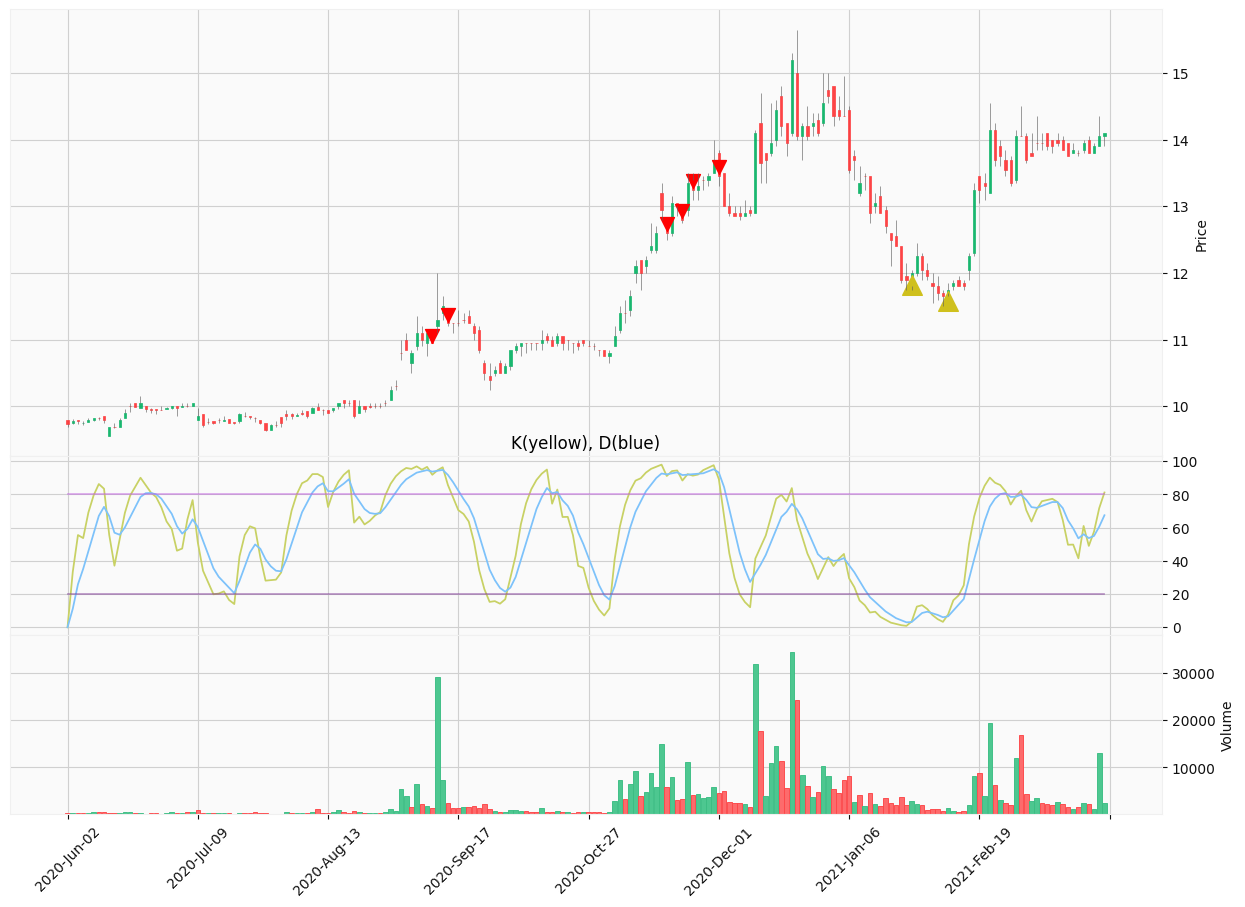

return rate: 0.0% | acc: 0.0%
../../parse_data/data/splited/1443.csv


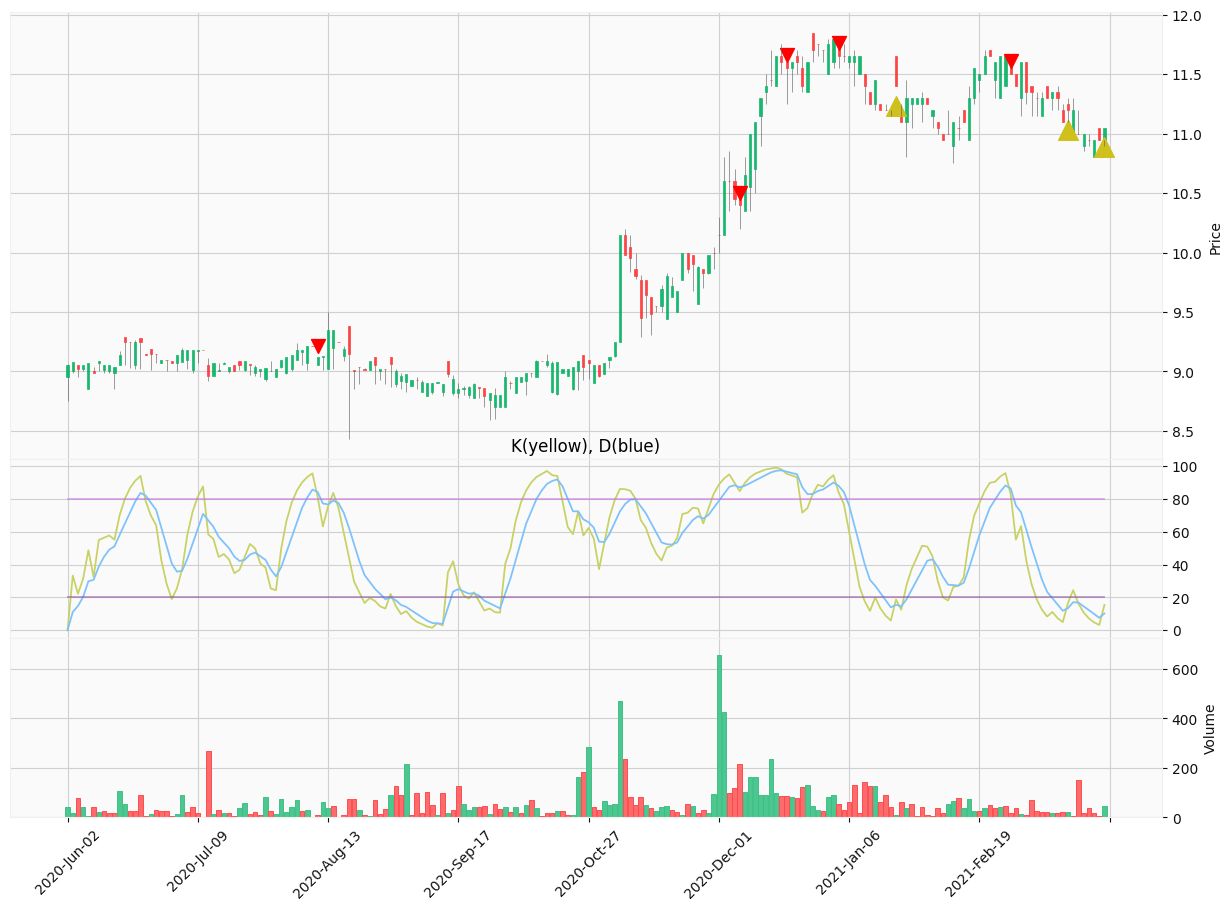

return rate: 0.9% | acc: 100.0%
return rate:
     bound_cross
2010        0.0%
1443        0.9%

accuracy:
     bound_cross
2010        0.0%
1443      100.0%


In [21]:
random_choice_num = 2
data_directory = '../../parse_data/data/splited/'
ticker_name_file=  '../../parse_data/data/ticker_name.csv'

strategy_list = [bound_cross]
dictionary_rr = {}
dictionary_acc = {}

for data_file in file_list_with_directory(random_sample(ticker_list_file = ticker_name_file, times = random_choice_num), data_directory):
    
    slim_file_name = (data_file.split('/')[-1]).split('.')[0]

    print(data_file)
    ticker = get_dataframe(data_file, days=200)
    ticker = kd_indicator(ticker)
    
    strategy_rr= []
    strategy_acc = []
    for i in range(len(strategy_list)):
        
        data = strategy_list[i](ticker)
        return_rate, acc = backtesting(data)
        
        return_rate = str(round(return_rate, 1))+'%'
        acc = str(round(acc, 3))+'%'
        print('return rate: {} | acc: {}'.format(return_rate, acc))
        strategy_rr.append(return_rate)
        strategy_acc.append(acc)
    

    #print(strategy_rr)
    #print(strategy_acc)
    
    dictionary_rr[slim_file_name] = strategy_rr
    dictionary_acc[slim_file_name] = strategy_acc


strategy_names = [i.__name__ for i in strategy_list]
dataframe_return_rate = pd.DataFrame.from_dict(dictionary_rr, orient='index',columns = strategy_names)
dataframe_acc = pd.DataFrame.from_dict(dictionary_acc ,orient='index',columns = strategy_names)

print('return rate:')
print(dataframe_return_rate)

print()
print('accuracy:')
print(dataframe_acc)
